## Python Example

In [1]:
from utils.dataframes import *

meter_usage

,service_point_id,meter_id,interval_end_datetime,meter_channel,kwh,account_number
0,2300822246,L108605388,10/1/2022 12:00:00 AM,10,0.594,30010320353
1,2300822246,L108605388,10/1/2022 12:15:00 AM,10,0.101,30010320353
2,2300822246,L108605388,10/1/2022 12:30:00 AM,10,0.104,30010320353
3,2300822246,L108605388,10/1/2022 12:45:00 AM,10,0.106,30010320353
4,2300822246,L108605388,10/1/2022 1:00:00 AM,10,0.099,30010320353
...,...,...,...,...,...,...
500275,2300588897,L108607371,9/30/2021 7:00:00 PM,10,1.242,35012790198
500276,2300588897,L108607371,9/30/2021 8:00:00 PM,10,1.202,35012790198
500277,2300588897,L108607371,9/30/2021 9:00:00 PM,10,1.186,35012790198
500278,2300588897,L108607371,9/30/2021 10:00:00 PM,10,1.150,35012790198


## SQL Example

In [2]:
from utils.runtime import connect_to_db

electric_brew = connect_to_db()

electric_brew.execute("SELECT * FROM meter_usage").fetchdf()

,service_point_id,meter_id,interval_end_datetime,meter_channel,kwh,account_number
0,2300588853,L123057647,10/1/2022 12:00:00 AM,10,0.043,35012787756
1,2300588853,L123057647,10/1/2022 12:15:00 AM,10,0.040,35012787756
2,2300588853,L123057647,10/1/2022 12:30:00 AM,10,0.045,35012787756
3,2300588853,L123057647,10/1/2022 12:45:00 AM,10,0.040,35012787756
4,2300588853,L123057647,10/1/2022 1:00:00 AM,10,0.045,35012787756
...,...,...,...,...,...,...
500275,2300588897,L108607371,9/30/2021 7:00:00 PM,10,1.242,35012790198
500276,2300588897,L108607371,9/30/2021 8:00:00 PM,10,1.202,35012790198
500277,2300588897,L108607371,9/30/2021 9:00:00 PM,10,1.186,35012790198
500278,2300588897,L108607371,9/30/2021 10:00:00 PM,10,1.150,35012790198


In [3]:
electric_brew.close()

## Advanced Analysis Ideas

#### Ideas

1. **Model Validation the Right Way: Holdout Sets**
   - ~~Develop a model validation strategy using holdout sets extracted from the `fct_electric_brew` dataset. These sets should focus on different billing intervals, various meters, and distinct operational periods (like peak and off-peak hours). The objective is to assess the model's predictive accuracy in real-world scenarios, especially for forecasting energy consumption and associated costs during different periods.~~

   - Plot residuals for each of the models' holdout sets  
<br>

1. **Model Validation via Cross-Validation**
   - Implement a robust cross-validation framework on `dim_datetimes` and `fct_electric_brew` datasets. This framework should assess the consistency and reliability of predictive models across various temporal segments, such as different months, weeks, or specific operational hours, to enhance the accuracy of peak hour energy consumption predictions.  
<br>

1. **Selecting the Best Model**
   - Conduct comparative analyses of different predictive modeling approaches, such as linear regression, decision trees, and ensemble methods. This comparison should leverage data from `dim_meters` and `dim_bills`, focusing on identifying the most efficient model for predicting energy usage patterns across different brewery operations and optimizing energy costs.  
<br>

1. **The Bias-Variance Trade-off**
   - Apply and fine-tune different machine learning models using `dim_datetimes` and `fct_electric_brew` datasets, with a focus on balancing model complexity. The goal is to achieve an optimal bias-variance trade-off, thereby avoiding overfitting or underfitting, and enhancing the model's generalization ability in predicting energy usage patterns.  
<br>

1. **Learning Curves**
   - Analyze learning curves by incrementally increasing the volume of training data from the `fct_electric_brew` dataset, which includes varied energy consumption patterns. Evaluate how different machine learning models improve or stabilize in performance as more data is fed into them. This analysis aims to determine the point of diminishing returns in terms of data volume and its effect on model performance.  
<br>

1. **Categorical Feature Engineering**
   - Transform and engineer categorical features from the `dim_datetimes` dataset, such as time segments (morning, afternoon, peak hours, off-peak hours) into quantifiable features. These features will be used in predictive models to assess their impact on energy usage patterns and to improve the accuracy of predictions.  
<br>

1. **Imputation of Missing Data**
   - Implement data imputation strategies to address missing or incomplete data points in `dim_meters` and `fct_electric_brew`. Use statistical techniques or machine learning-based imputation methods to fill gaps, aiming to enhance the overall accuracy and reliability of time series forecasting models focused on peak hour energy usage.  
<br>

1. **Feature Pipelines**
   - Develop and establish data preprocessing pipelines for `dim_datetimes` and `dim_bills`, focusing on efficient and consistent preparation of data for predictive modeling. These pipelines should include steps like normalization, encoding of categorical variables, and handling of missing values, ensuring that data fed into the models is clean and standardized.  
<br>

1. **Bayesian Classification**
   - Utilize Bayesian classification techniques on the `fct_electric_brew` dataset to make probabilistic predictions about energy usage patterns. This approach will be particularly beneficial in assessing the likelihood of different consumption patterns and their impact on cost, which is crucial in ROI analyses and risk assessment.  
<br>

1.  **Polynomial Basis Functions**
    - Investigate and model non-linear relationships within the `dim_datetimes` and `fct_electric_brew` datasets. This exploration should focus on uncovering complex patterns in energy consumption during peak hours, using polynomial basis functions to represent these non-linear relationships in the predictive models.  
<br>

1.  **Regularization**
    - Implement regularization techniques in predictive models that combine features from `dim_datetimes`, `dim_meters`, `dim_bills`, and `fct_electric_brew`. The goal is to control model complexity, particularly in models predicting various aspects of energy consumption, and prevent overfitting by penalizing large or irrelevant model coefficients.  
<br>

1.  **Lasso Regression**
    - Apply Lasso regression across all dimensions, including `dim_datetimes`, `dim_meters`, `dim_bills`, and `fct_electric_brew`, to conduct feature selection. This method will identify the most impactful predictors across different datasets, revealing the variables that significantly influence peak hour energy consumption and cost patterns.  
<br>

1.  **Decision Trees and Random Forests**
    - Implement decision tree and random forest algorithms on the `fct_electric_brew` dataset. These methods will be used to build robust models for predicting energy usage, with a focus on identifying and understanding the key factors and variables that significantly influence energy consumption during peak hours.  
<br>

1.  **Principal Component Analysis**
    - Perform Principal Component Analysis (PCA) on the `dim_bills` dataset to reduce its dimensionality. This technique will help in identifying the most significant billing factors and underlying patterns, simplifying complex billing data into principal components that retain the most important information for predictive modeling.  
<br>

1.  **Anomaly Detection**
    - Deploy anomaly detection algorithms to identify unusual patterns or outliers in cost and consumption data within the `fct_electric_brew` dataset. This analysis aims to pinpoint inefficiencies, potential errors, or opportunities for cost savings, especially in peak hour energy usage.  
<br>

1.  **Time-Based Forecasting**
    - Use advanced time series forecasting methods on `dim_datetimes` and `dim_bills` to predict future energy costs and consumption patterns. This forecasting will help in strategic planning and decision-making, particularly in identifying potential benefits of shifting energy usage to off-peak times.  
<br>

1.  **K-Means Clustering**
    - Apply K-Means Clustering to the `fct_electric_brew` dataset to segment and analyze different patterns of energy consumption and associated costs. This clustering will assist in identifying distinct consumption groups or patterns within the brewery, facilitating targeted strategies for cost reduction and energy management.  


### 1. Model Validation Strategies Using Holdout Sets

Develop a model validation strategy using holdout sets extracted from the `fct_electric_brew` dataset. These sets should focus on different billing intervals, various meters, and distinct operational periods (like peak and off-peak hours). The objective is to assess the model's predictive accuracy in real-world scenarios, especially for forecasting energy consumption and associated costs during different periods.

Linear Regression
    MSE: 0.0126
    MAE: 0.0549
    R²:  0.7631
Random Forest
    MSE: 0.0027
    MAE: 0.0080
    R²:  0.9489
Gradient Boosting
    MSE: 0.0059
    MAE: 0.0259
    R²:  0.8895


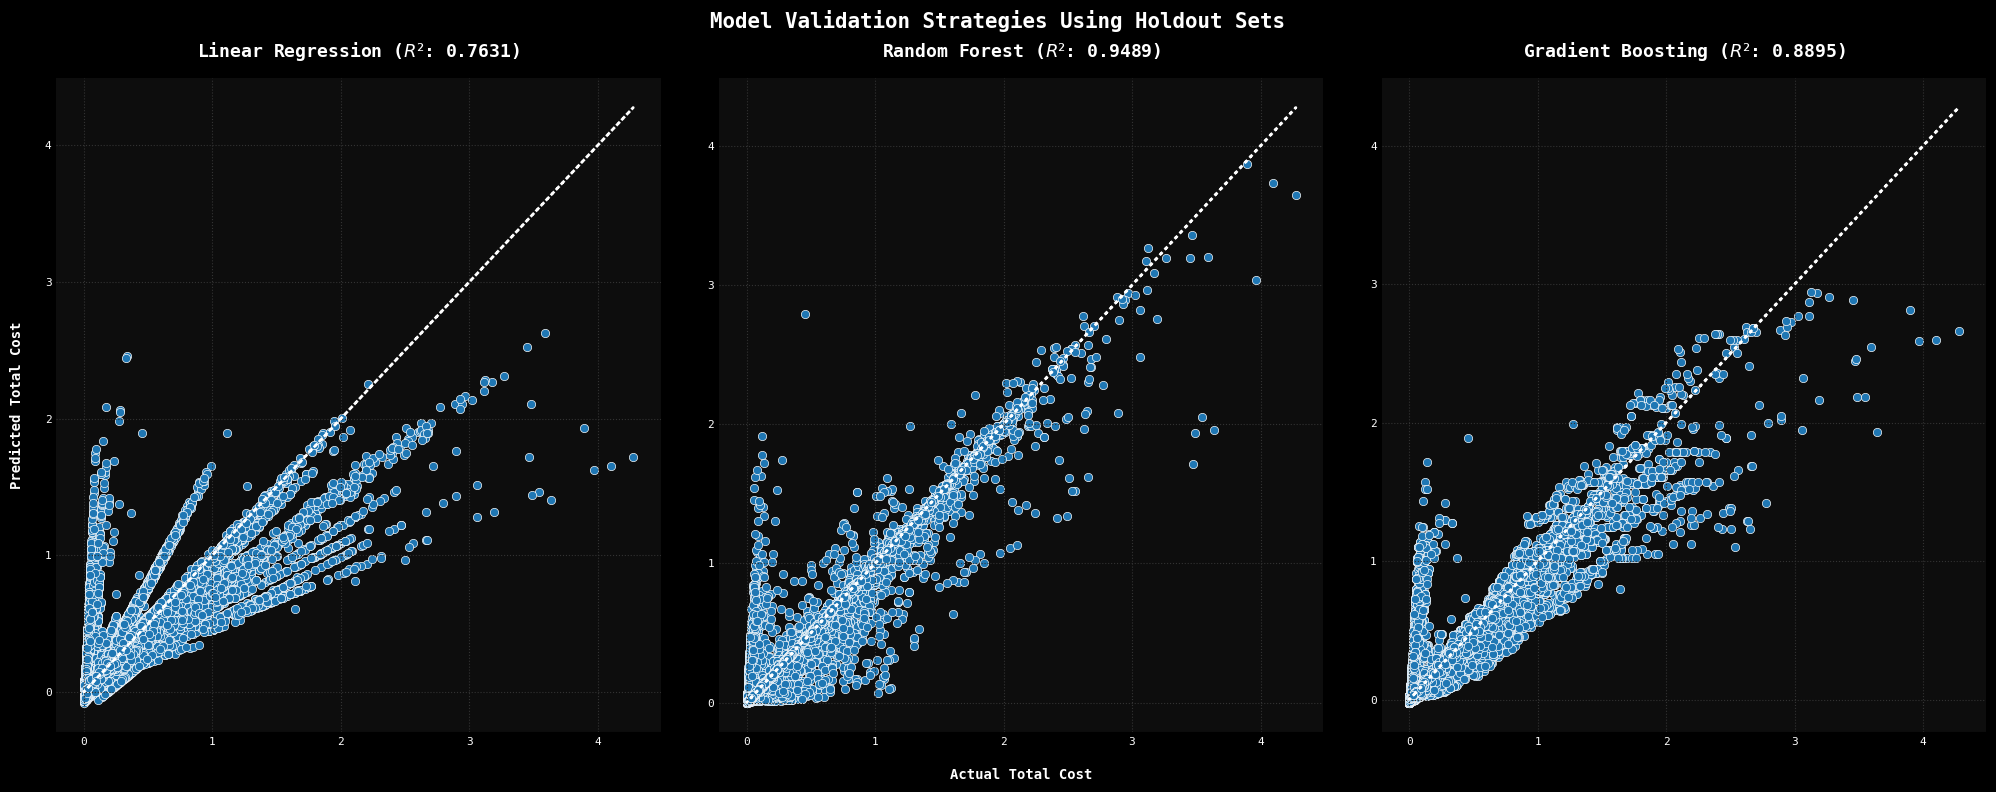

In [4]:
'''
Model Validation Strategies Using Holdout Sets

This script develops a model validation strategy using holdout sets from the `fct_electric_brew` dataset. The focus is on forecasting 
energy consumption and associated costs across different periods, particularly comparing peak and off-peak hours. 

Methodology:
    1. Data preparation involving feature extraction and cleaning.
    2. Stratified dataset splitting to ensure diverse representation in the holdout set.
    3. Model selection and training on a variety of regression algorithms.
    4. Model validation and tuning on a separate validation set.
    5. Final evaluation and visualization on the holdout set with a focus on predictive accuracy during various operational periods.
    6. Visualization of model performance and insights derivation.

Key Metrics:
    - RMSE, MAE for quantitative accuracy.
    - R² to measure the proportion of the variance for the dependent variable.

Produces:
    - A trained and validated model with performance insights.
    - Visualizations of model predictions and performance.
    - A report summarizing key findings and operational recommendations.
'''

'''
To-do:
- Colormaps for each plot, colored by distance from perfect plot
- Nicer marker formatting
- General refactor for performance (e.g. same preprocessor 3 times?)
'''

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose         import ColumnTransformer
from sklearn.ensemble        import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler, OneHotEncoder

from utils.dataframes import fct_electric_brew, dim_datetimes, dim_meters, dim_bills
from utils.runtime    import setup_plot_params

setup_plot_params()

# Step 1: Data Preparation

# Joining fact and dimension tables
data = fct_electric_brew.merge(dim_datetimes, left_on = 'dim_datetimes_id', right_on = 'id', suffixes = ('', '_dd')) \
                        .merge(dim_meters,    left_on = 'dim_meters_id',    right_on = 'id', suffixes = ('', '_dm')) \
                        .merge(dim_bills,     left_on = 'dim_bills_id',     right_on = 'id', suffixes = ('', '_db'))

# Feature selection and engineering
features = data[['hour', 'week', 'month', 'quarter', 'year', 'period', 'meter_id', 'supplier', 'kwh']]
target   = data['total_cost']

# Step 2: Splitting the Dataset
X_train, X_holdout, y_train, y_holdout = train_test_split(features, 
                                                          target, 
                                                          test_size    = 0.3, 
                                                          random_state = 42)

# Step 3: Model Selection
# Preprocessing for numerical and categorical features
categorical = ['period', 'meter_id', 'supplier']
numerical   = [col for col in features.columns if col not in categorical]

preprocessor = ColumnTransformer(transformers = [('num', StandardScaler(), numerical),
                                                 ('cat', OneHotEncoder(),  categorical)])

# Define models within a pipeline to ensure consistent preprocessing
models = {'Linear Regression' : Pipeline([('preprocessor', preprocessor), 
                                          ('regressor',    LinearRegression())]),

          'Random Forest'     : Pipeline([('preprocessor', preprocessor), 
                                          ('regressor',    RandomForestRegressor())]),

          'Gradient Boosting' : Pipeline([('preprocessor', preprocessor), 
                                          ('regressor',    GradientBoostingRegressor())])}

# Step 4: Training and Validation
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)

# Step 5: Combined Model Evaluation and Visualization
plt.figure(figsize = (20, 8))

for i, (name, pipeline) in enumerate(models.items()):
    # Model evaluation
    y_pred = pipeline.predict(X_holdout)
    r2 = r2_score(y_holdout, y_pred)

    # Print model performance metrics
    print(f"{name}",
          f"    MSE: {mean_squared_error(y_holdout, y_pred):.4f}",
          f"    MAE: {mean_absolute_error(y_holdout, y_pred):.4f}",    
          f"    R²:  {r2:.4f}",
          sep='\n')

    # Model visualization
    plt.subplot(1, len(models), i + 1)
    sns.scatterplot(x = y_holdout, y = y_pred)
    plt.plot(y_holdout, y_holdout, color = '1', linewidth = 2, linestyle = ':') # Perfect prediction line
    plt.xlabel('Actual Total Cost'    if i == 1 else ' ')
    plt.ylabel('Predicted Total Cost' if i == 0 else ' ')
    plt.title(f'{name} ($R²$: {r2:.4f})')

plt.suptitle('Model Validation Strategies Using Holdout Sets', weight = 'bold', fontsize = 15)
plt.tight_layout()
plt.show()